#  GlobalAiHub Boot Camp  Final Project 

- **Mustafa Fatih ŞEN**
- **Soner Ünal**
- **Rıza Can Fırat**


# Importing required modules

In [103]:

import tensorflow as tf
import tensorflow.keras
import cv2
import librosa
import numpy as np

import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation,Dropout, BatchNormalization
from tensorflow.keras import Sequential
from sklearn.metrics import classification_report, confusion_matrix


import librosa as _librosa
import librosa.display as _display
import matplotlib.pyplot as plt

import glob,os

# Function to create spectrograms from given sound

In [2]:
def create_specetrogram(y:np.ndarray,classNum,filename) -> bool:
    """ This function creates a specetrogram from given data y and  saves with the filename to ralated class folder"""
    try:
        # form a out directory structure if not exist
        if not os.path.isdir(f"spectrograms/{classNum}"):
            os.makedirs(f"spectrograms/{classNum}")

        # form spectrograms from given array y
        spec = librosa.feature.melspectrogram(y=y)
        spec_conv = librosa.amplitude_to_db(spec,ref=np.max)

        # save the spectrograms to related folder
        fig,ax = plt.subplots(1)
        fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
        ax.axis('off')
        df = librosa.display.specshow(spec_conv )
        
        fig.savefig(f'spectrograms/{classNum}/{filename}.png')
        fig.clear()
        plt.close()

        return True
    except Exception as err:
        print(str(err))
        return False

In [3]:


## creates sound images 

soundDirPath = "UrbanSound8K/audio"
soundMetadataPath = "UrbanSound8K/metadata/UrbanSound8K.csv"

## read metadata file
metadataFile = open(soundMetadataPath)
metadata = metadataFile.readlines()

#create spectrograms
for i in metadata[1:]:
    try:
        slice_file_name,fsID,start,end,salience,fold,classID,classs  = i.split(",")
        y, sr = librosa.load(os.path.join(soundDirPath,f"fold{fold}",slice_file_name))
        result = create_specetrogram(y,classID,os.path.splitext(slice_file_name)[0])
        if not result:
            raise f"error at file {slice_file_name}"
    
    except Exception as err:
        print(err)



# Reading all sound images

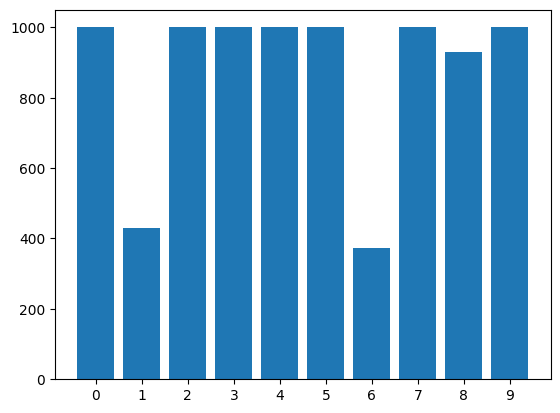

In [2]:
### Prepare train and test sets

# read all images paths
imgPathDir = "spectrograms"

imgPathsList = []
imgClass = []
frq = defaultdict(int)


for path in glob.glob(os.path.join(imgPathDir,"*/*.png")):
    imgPathsList.append(path)
    imgClass.append(path.split("-")[1])
    frq[path.split("-")[1]] += 1
    
        

### plot bar graph by frequency
w = list(frq.keys())
h = list(frq.values())
plt.bar(w,h)
plt.show()




# Random view one of the image

Image shape: (480, 640, 4)


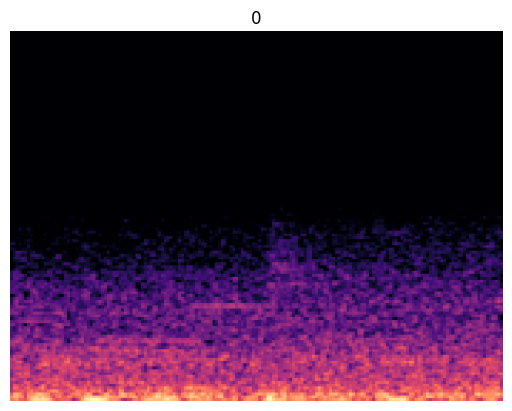

In [32]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+"/"+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

img = view_random_image(imgPathDir,str(random.choice(list(range(10)))))

# Creating test, train and validation sets

In [4]:
## split dataset into train, test and validation

x = imgPathsList
y = imgClass


# First, create X_train, y_train and X_temporary and y_temporary datasets from X and y.
X_train,X_temporary, y_train,  y_temporary = train_test_split(x,y,train_size=0.8,shuffle=True,random_state=42)

# Using the X_temporary and y_temporary dataset we just created create validaiton and test datasets.
x_val, x_test , y_val, y_test = train_test_split(X_temporary,y_temporary,train_size=0.5,shuffle=True,random_state=42)

In [5]:
train = pd.DataFrame(X_train,columns=["filename"])
train["class"] = y_train

test = pd.DataFrame(x_test,columns=["filename"])
test["class"] = y_test

val = pd.DataFrame(x_val,columns=["filename"])
val["class"] = y_val



In [33]:
train.head()

,filename,class
0,spectrograms\9\60608-9-0-5.png,9
1,spectrograms\9\77901-9-0-6.png,9
2,spectrograms\2\9223-2-0-5.png,2
3,spectrograms\5\103249-5-0-5.png,5
4,spectrograms\7\169098-7-4-0.png,7


In [6]:

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255,                                    
                                    zoom_range=0.1, # zoom into the image
                                    width_shift_range=0.1, # shift the image width ways
                                    height_shift_range=0.1, # shift the image height ways
                                             )
valid_datagen = ImageDataGenerator(rescale=1./255)

X_train = train_datagen.flow_from_dataframe(train,
                                                y_col="class",
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(320, 240), # convert all images to be 320, 240
                                               class_mode="categorical", # type of problem we're working on
                                               color_mode = "grayscale",
                                               seed=42)

x_test = valid_datagen.flow_from_dataframe(test,
                                                y_col="class",
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(320, 240), # convert all images to be 320, 240
                                               class_mode="categorical", # type of problem we're working on
                                               color_mode = "grayscale",
                                               seed=42)

x_val = valid_datagen.flow_from_dataframe(val,
                                                y_col="class",
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(320, 240), # convert all images to be 320, 240
                                               class_mode="categorical", # type of problem we're working on
                                               color_mode = "grayscale",
                                               seed=42)

Found 6985 validated image filenames belonging to 10 classes.
Found 874 validated image filenames belonging to 10 classes.
Found 873 validated image filenames belonging to 10 classes.


# Model 1

In [34]:
cnnModel = Sequential([
  Conv2D(64, 3, activation='relu', input_shape=(320, 240,1)),
  Dropout(0.5),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(32, 5, activation='relu',padding='same'),
  MaxPool2D(),
  Dropout(0.2),
  Conv2D(16, 3, activation='relu',padding='same'),
  MaxPool2D(),
  Dropout(0.1),
  Flatten(),
  Dense(30, activation='relu'),
  Dropout(0.2),
  Dense(10, activation='softmax')
])

# Compile the model
cnnModel.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history = cnnModel.fit(X_train, # changed to augmented training data
                        epochs=10,
                        steps_per_epoch=len(X_train),
                        validation_data=x_val,
                        validation_steps=len(x_val))

Epoch 1/10
219/219 [==============================] - 87s 371ms/step - loss: 1.9911 - accuracy: 0.2709 - val_loss: 1.7330 - val_accuracy: 0.4215
Epoch 2/10
219/219 [==============================] - 52s 237ms/step - loss: 1.6698 - accuracy: 0.3807 - val_loss: 1.5266 - val_accuracy: 0.5006
Epoch 3/10
219/219 [==============================] - 52s 238ms/step - loss: 1.4817 - accuracy: 0.4462 - val_loss: 1.3387 - val_accuracy: 0.5052
Epoch 4/10
219/219 [==============================] - 51s 233ms/step - loss: 1.3592 - accuracy: 0.5008 - val_loss: 1.2337 - val_accuracy: 0.6025
Epoch 5/10
219/219 [==============================] - 52s 237ms/step - loss: 1.2464 - accuracy: 0.5424 - val_loss: 1.0899 - val_accuracy: 0.6243
Epoch 6/10
219/219 [==============================] - 52s 239ms/step - loss: 1.1923 - accuracy: 0.5599 - val_loss: 1.0578 - val_accuracy: 0.6541
Epoch 7/10
219/219 [==============================] - 52s 235ms/step - loss: 1.1686 - accuracy: 0.5797 - val_loss: 1.0418 - val_ac

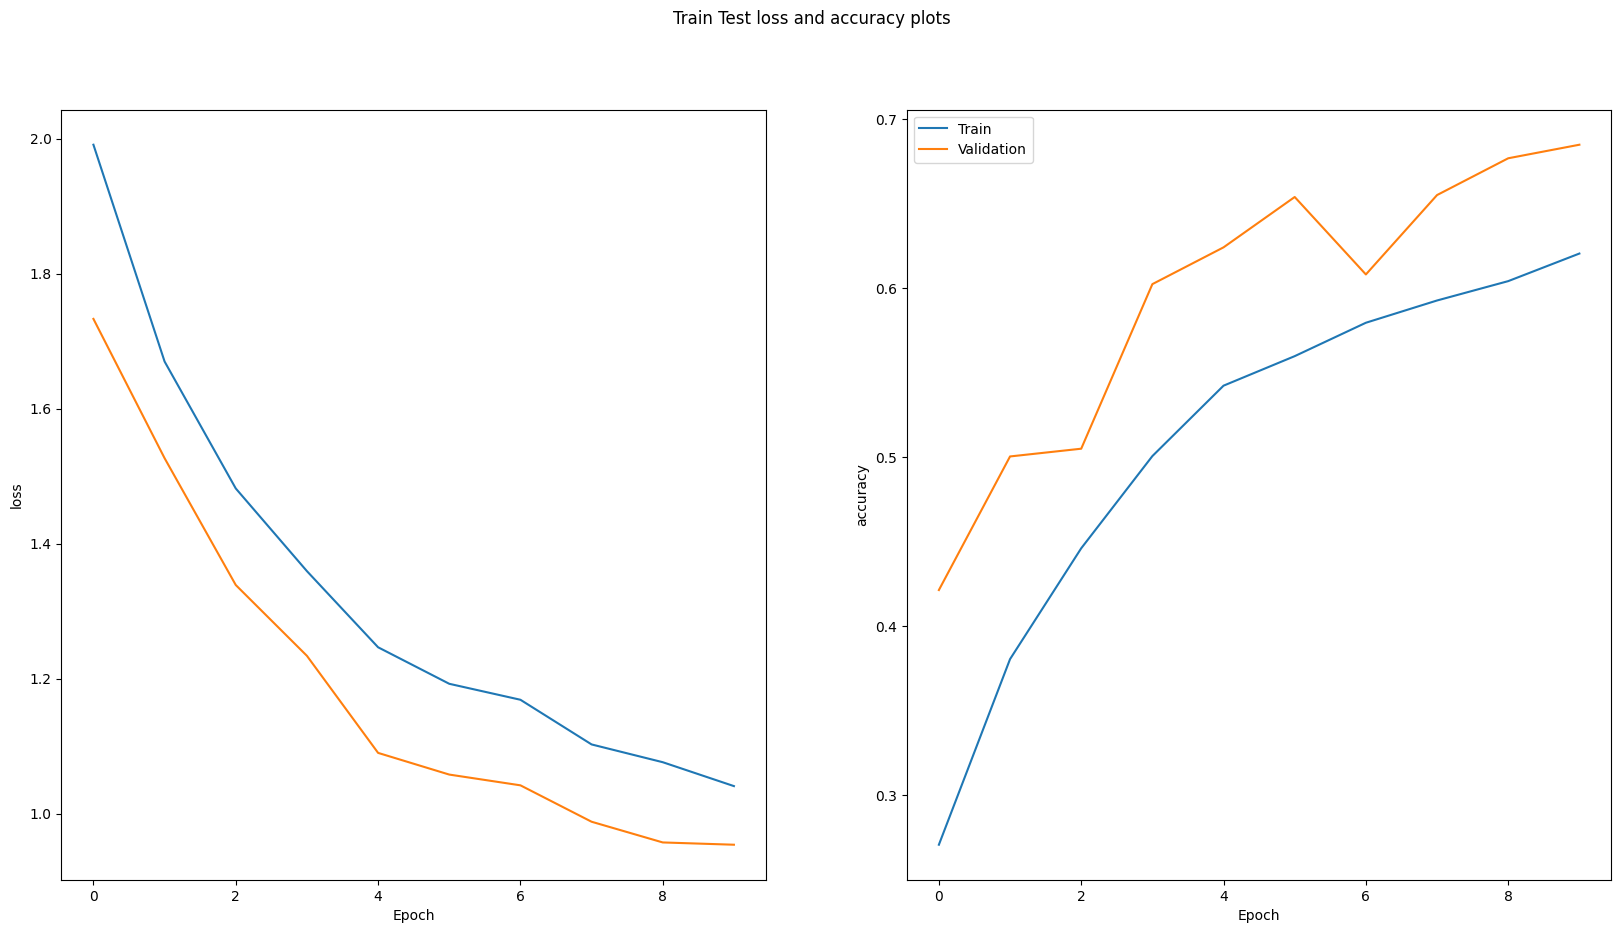

In [52]:
fig = plt.figure(figsize=(20,10))


(ax1, ax2) = fig.subplots(1, 2)
fig.suptitle('Train Test loss and accuracy plots')

ax1.plot(history.history['loss'],label='Train')
ax1.plot(history.history['val_loss'],label='Validation')

ax2.plot(history.history['accuracy'],label='Train')
ax2.plot(history.history['val_accuracy'],label='Validation')


# Name the x and y axises
ax1.set(xlabel='Epoch', ylabel='loss')
ax2.set(xlabel='Epoch', ylabel='accuracy')



# Put legend table
plt.legend()

# Show the plot
plt.show()

# Comment

- As it is shown in figure we thougt that model is in underfitting. To fix that we decide to train it more like in below.

# Model 2

In [36]:
cnnModel_2 = Sequential([
  Conv2D(64, 3, activation='relu', input_shape=(320, 240,1)),
  Dropout(0.5),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(32, 5, activation='relu',padding='same'),
  MaxPool2D(),
  Dropout(0.2),
  Conv2D(16, 3, activation='relu',padding='same'),
  MaxPool2D(),
  Dropout(0.1),
  Flatten(),
  Dense(30, activation='relu'),
  Dropout(0.2),
  Dense(10, activation='softmax')
])

# Compile the model
cnnModel_2.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history2 = cnnModel_2.fit(X_train, # changed to augmented training data
                        epochs=20,
                        steps_per_epoch=len(X_train),
                        validation_data=x_val,
                        validation_steps=len(x_val))

Epoch 1/20
219/219 [==============================] - 48s 217ms/step - loss: 1.9230 - accuracy: 0.2726 - val_loss: 1.6641 - val_accuracy: 0.5109
Epoch 2/20
219/219 [==============================] - 48s 221ms/step - loss: 1.5671 - accuracy: 0.4213 - val_loss: 1.4082 - val_accuracy: 0.5533
Epoch 3/20
219/219 [==============================] - 50s 228ms/step - loss: 1.4019 - accuracy: 0.4832 - val_loss: 1.2145 - val_accuracy: 0.5968
Epoch 4/20
219/219 [==============================] - 50s 228ms/step - loss: 1.2706 - accuracy: 0.5337 - val_loss: 1.1050 - val_accuracy: 0.6105
Epoch 5/20
219/219 [==============================] - 50s 227ms/step - loss: 1.2036 - accuracy: 0.5615 - val_loss: 1.0582 - val_accuracy: 0.6724
Epoch 6/20
219/219 [==============================] - 47s 215ms/step - loss: 1.1147 - accuracy: 0.5930 - val_loss: 0.9464 - val_accuracy: 0.6976
Epoch 7/20
219/219 [==============================] - 50s 227ms/step - loss: 1.0785 - accuracy: 0.6087 - val_loss: 1.0127 - val_ac

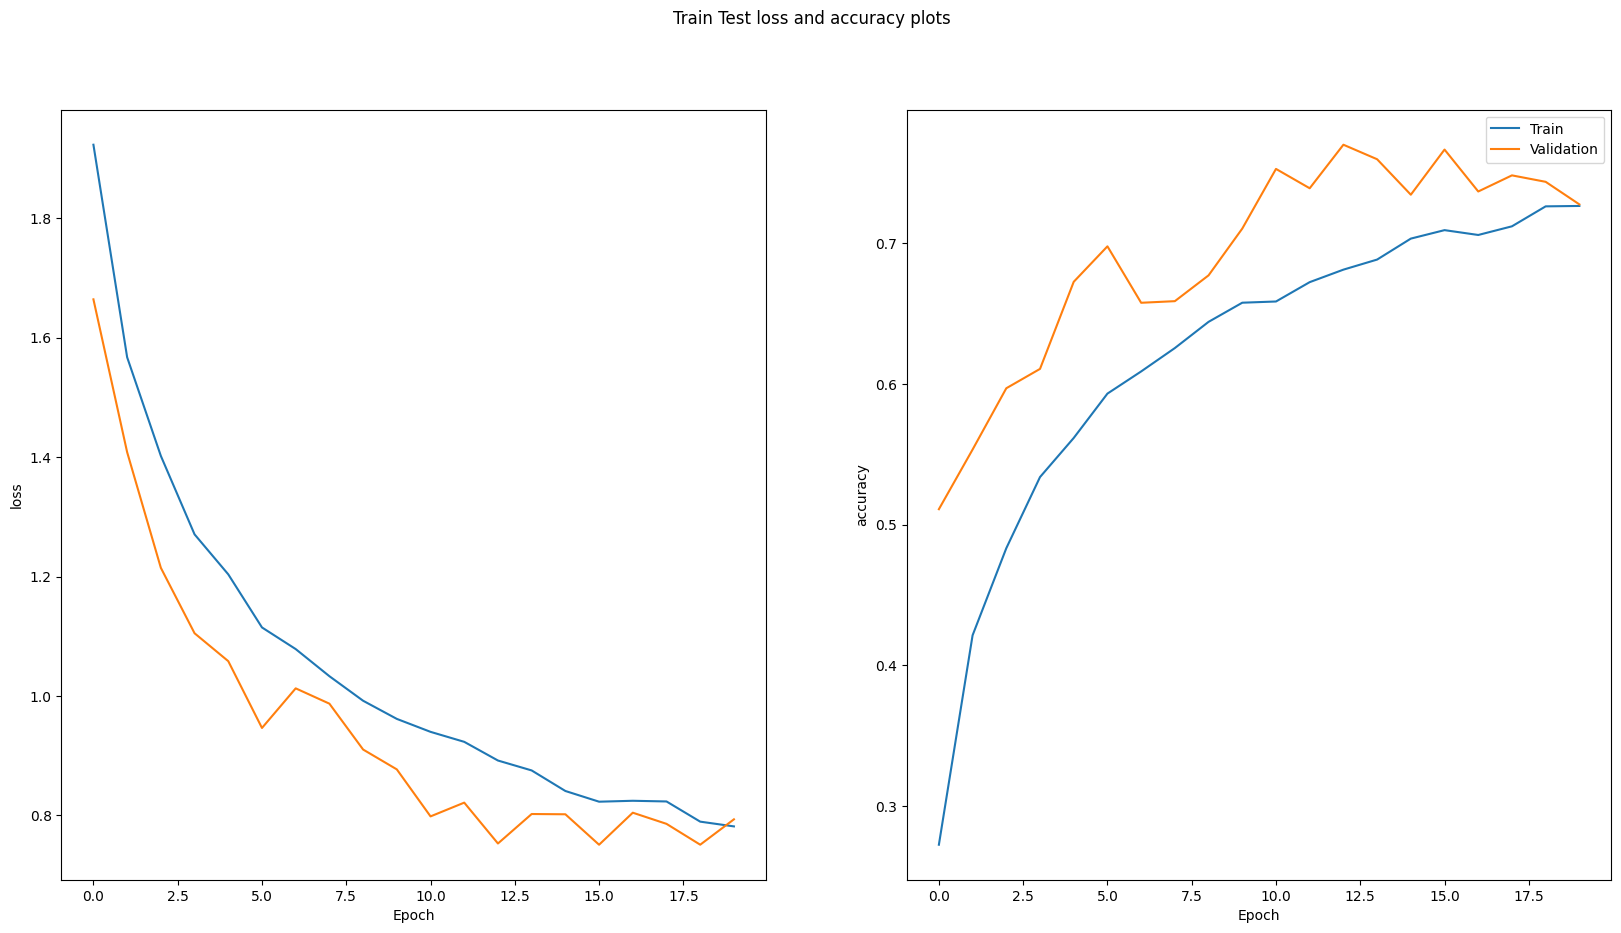

In [53]:
fig = plt.figure(figsize=(20,10))


(ax1, ax2) = fig.subplots(1, 2)
fig.suptitle('Train Test loss and accuracy plots')

ax1.plot(history2.history['loss'],label='Train')
ax1.plot(history2.history['val_loss'],label='Validation')

ax2.plot(history2.history['accuracy'],label='Train')
ax2.plot(history2.history['val_accuracy'],label='Validation')


# Name the x and y axises
ax1.set(xlabel='Epoch', ylabel='loss')
ax2.set(xlabel='Epoch', ylabel='accuracy')



# Put legend table
plt.legend()

# Show the plot
plt.show()

In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint
import datetime
## Create checkpoint call back to save checkpoint
filepath="weights-improvement-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
callbacks_list = [checkpoint,tensorboard_callback]

# Model 3

In [106]:
cnnModel_3 = Sequential([
  Conv2D(8, 3, activation='relu', input_shape=(320, 240,1)),
  Conv2D(16, 3, activation='relu',padding='same'),
  Dropout(0.5),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(32, 3, activation='relu',padding='same'),
  Conv2D(64, 3, activation='relu',padding='same'),
  MaxPool2D(),
  BatchNormalization(),
  Conv2D(16, 3, activation='relu',padding='same'),
  Conv2D(8, 3, activation='relu',padding='same'),
  Dropout(0.3),
  MaxPool2D(),
  
  Flatten(),
  Dense(40, activation='relu'),
  Dense(15, activation='relu'),
  Dense(10, activation='softmax')
])

# Compile the model
cnnModel_3.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history3 = cnnModel_3.fit(X_train, # changed to augmented training data
                        epochs=100,
                        steps_per_epoch=len(X_train),
                        validation_data=x_val,
                        validation_steps=len(x_val),
                        callbacks=callbacks_list)

Epoch 1/100
219/219 [==============================] - 52s 231ms/step - loss: 1.8624 - accuracy: 0.3231 - val_loss: 2.2107 - val_accuracy: 0.2325

Epoch 00001: val_accuracy did not improve from 0.83276
Epoch 2/100
219/219 [==============================] - 47s 214ms/step - loss: 1.3613 - accuracy: 0.5122 - val_loss: 1.8040 - val_accuracy: 0.4513

Epoch 00002: val_accuracy did not improve from 0.83276
Epoch 3/100
219/219 [==============================] - 48s 218ms/step - loss: 1.1813 - accuracy: 0.5865 - val_loss: 1.4290 - val_accuracy: 0.5006

Epoch 00003: val_accuracy did not improve from 0.83276
Epoch 4/100
219/219 [==============================] - 47s 215ms/step - loss: 1.0758 - accuracy: 0.6176 - val_loss: 1.3037 - val_accuracy: 0.5590

Epoch 00004: val_accuracy did not improve from 0.83276
Epoch 5/100
219/219 [==============================] - 47s 214ms/step - loss: 1.0316 - accuracy: 0.6401 - val_loss: 1.1820 - val_accuracy: 0.6025

Epoch 00005: val_accuracy did not improve fro

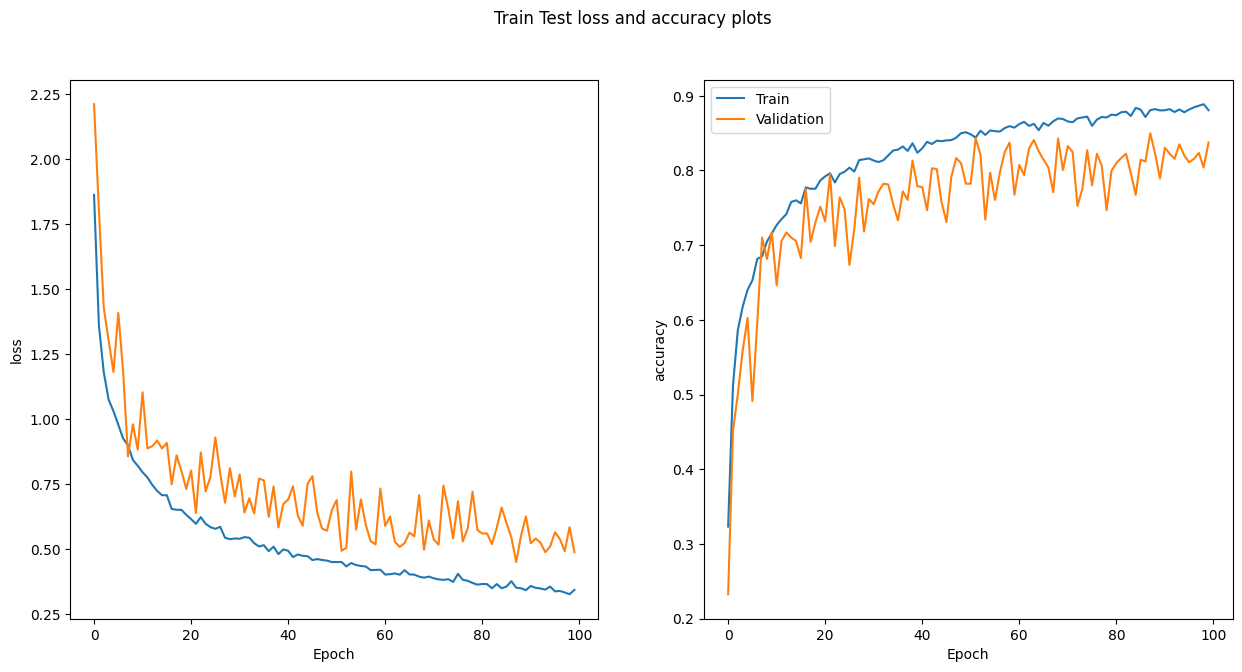

In [107]:

fig = plt.figure(figsize=(15,7))


(ax1, ax2) = fig.subplots(1, 2)
fig.suptitle('Train Test loss and accuracy plots')

ax1.plot(history3.history['loss'],label='Train')
ax1.plot(history3.history['val_loss'],label='Validation')

ax2.plot(history3.history['accuracy'],label='Train')
ax2.plot(history3.history['val_accuracy'],label='Validation')


# Name the x and y axises
ax1.set(xlabel='Epoch', ylabel='loss')
ax2.set(xlabel='Epoch', ylabel='accuracy')



# Put legend table
plt.legend()

# Show the plot
plt.show()



# Model Evaluation

In [108]:
# draw confusion matrix
# new ver: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# old ver: https://scikit-learn.org/0.21/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          percentage = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax




In [109]:
test_result = cnnModel_3.evaluate(x_test)
# Print the result
print(test_result) # first one is loss and second is accuracy

28/28 [==============================] - 3s 94ms/step - loss: 0.4663 - accuracy: 0.8490
[0.46627235412597656, 0.8489702343940735]


In [61]:
## Preparing test set for evaluation

label = []
img = []
for i in range(28):
    for j in range(32):
        try:
            label.append(list(x_test[i][1][j]).index(1))
            img.append(list(x_test[i][0][j]))
        except:
            pass

In [110]:
y_probs = cnnModel_3.predict(np.array(img))
y_predicts = np.argmax(y_probs, axis=1)

In [111]:

cm =  confusion_matrix(label, y_predicts)
cm


array([[71,  0,  0,  0,  0, 12,  2,  2,  0,  0],
       [ 2, 41,  0,  0,  3,  1,  0,  2,  0,  3],
       [ 0,  0, 97,  7,  0,  1,  0,  0,  0,  2],
       [ 1,  0,  3, 92,  0,  1,  3,  0,  0,  0],
       [ 4,  1,  1,  1, 72,  4,  1,  6,  1,  0],
       [ 9,  3,  0,  1,  0, 74,  3,  3,  0,  0],
       [ 0,  0,  0,  0,  1,  0, 38,  0,  0,  0],
       [ 2,  0,  0,  0,  4,  5,  7, 89,  0,  1],
       [ 0,  1,  1,  0,  1,  1,  3,  0, 78,  0],
       [ 3,  2,  8,  1,  3,  1,  2,  2,  0, 90]], dtype=int64)

In [112]:
#Evaluation of model with validation data


np.set_printoptions(precision=2)
     

labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

re = classification_report(y_predicts, label, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)




                  precision    recall  f1-score   support

 Air Conditioner       0.82      0.77      0.79        92
        Car Horn       0.79      0.85      0.82        48
Children Playing       0.91      0.88      0.89       110
        Dog bark       0.92      0.90      0.91       102
        Drilling       0.79      0.86      0.82        84
   Engine Idling       0.80      0.74      0.77       100
        Gun Shot       0.97      0.64      0.78        59
      Jackhammer       0.82      0.86      0.84       104
           Siren       0.92      0.99      0.95        79
    Street Music       0.80      0.94      0.87        96

        accuracy                           0.85       874
       macro avg       0.85      0.84      0.84       874
    weighted avg       0.85      0.85      0.85       874



Confusion matrix, without normalization


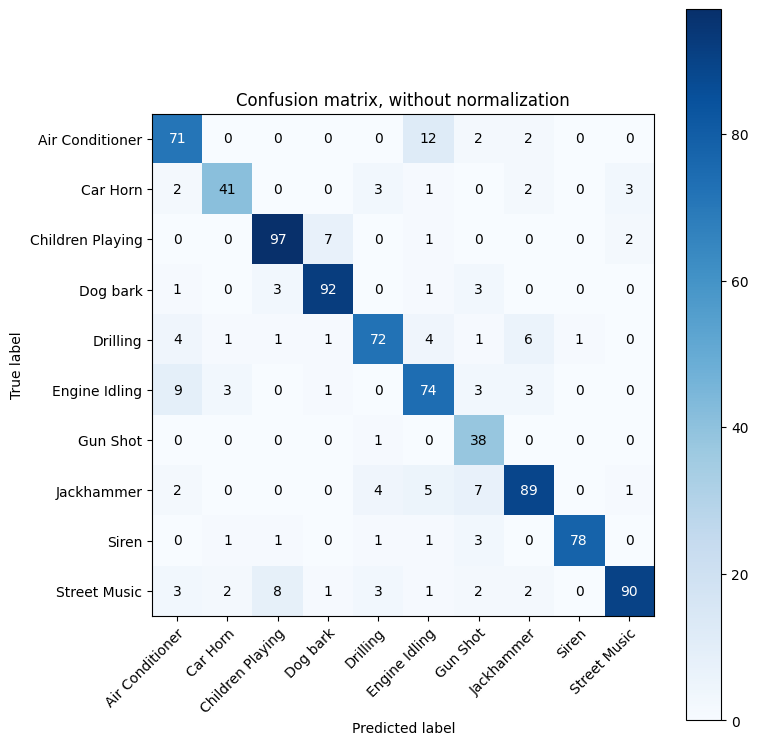

In [113]:
plot_confusion_matrix(label, y_predicts, classes=labels, cmap=plt.cm.Blues, normalize= False)
plt.show()

# Loading Best Accurate Model

In [120]:
bestModel = tf.keras.models.load_model("weights-improvement-52.hdf5")
test_result = bestModel.evaluate(x_test)
# Print the result
print(test_result) # first one is loss and second is accuracy

28/28 [==============================] - 3s 99ms/step - loss: 0.4577 - accuracy: 0.8684
[0.4576629102230072, 0.8684210777282715]


In [121]:
y_probs2 = bestModel.predict(np.array(img))
y_predicts2 = np.argmax(y_probs2, axis=1)
cm =  confusion_matrix(label, y_predicts2)
cm

array([[76,  0,  1,  0,  0,  8,  1,  1,  0,  0],
       [ 2, 41,  0,  0,  1,  1,  0,  2,  0,  5],
       [ 1,  0, 90,  9,  0,  0,  0,  0,  0,  7],
       [ 0,  0,  5, 91,  1,  1,  0,  0,  1,  1],
       [ 3,  1,  1,  0, 79,  3,  0,  1,  2,  1],
       [ 7,  1,  1,  0,  2, 80,  0,  0,  1,  1],
       [ 0,  0,  0,  1,  1,  0, 37,  0,  0,  0],
       [ 0,  0,  0,  0,  7,  8,  4, 88,  0,  1],
       [ 1,  1,  2,  1,  0,  1,  0,  0, 78,  1],
       [ 3,  1,  4,  0,  1,  2,  0,  2,  0, 99]], dtype=int64)

In [122]:
#Evaluation of model with validation data


np.set_printoptions(precision=2)
     

labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

re = classification_report(y_predicts2, label, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)


                  precision    recall  f1-score   support

 Air Conditioner       0.87      0.82      0.84        93
        Car Horn       0.79      0.91      0.85        45
Children Playing       0.84      0.87      0.85       104
        Dog bark       0.91      0.89      0.90       102
        Drilling       0.87      0.86      0.86        92
   Engine Idling       0.86      0.77      0.81       104
        Gun Shot       0.95      0.88      0.91        42
      Jackhammer       0.81      0.94      0.87        94
           Siren       0.92      0.95      0.93        82
    Street Music       0.88      0.85      0.87       116

        accuracy                           0.87       874
       macro avg       0.87      0.87      0.87       874
    weighted avg       0.87      0.87      0.87       874



Confusion matrix, without normalization


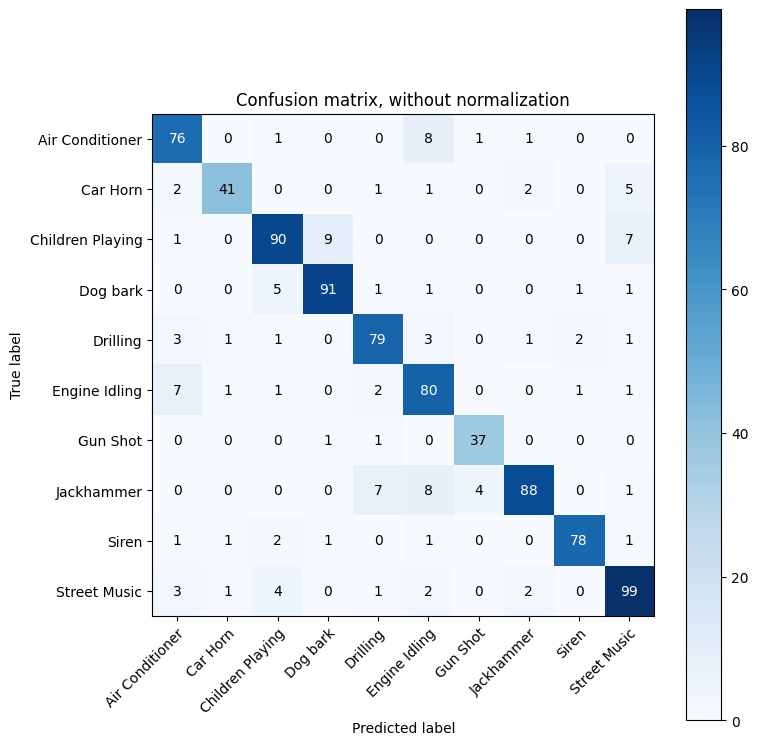

In [123]:
plot_confusion_matrix(label, y_predicts2, classes=labels, cmap=plt.cm.Blues, normalize= False)
plt.show()